In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv(override=True)

True

## User Clarification and Brief Generation

The goal of scoping is to gather user-context needed for research.

### Overall Flow

<img src="./assets/overall_flow.png" width=1200>


We shall scope the research in two phases:

1. User Clarification : Determines if additional clarification is needed from the user
2. Brief Generation : Transforms the conversation into a detailed  research brief

<img src="./assets/scoping_flow.png" width=800>

In [2]:
from utils import show_prompt
from deep_research_with_langgraph.prompts import clarify_with_user_instructions
show_prompt(clarify_with_user_instructions, "Clarify with User Instructions")

╭──────────────────────────────────────── Clarify with User Instructions ─────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  These are the messages that have been exchanged so far from the user asking for the report:                    │
│  <Messages>                                                                                                     │
│  {messages}                                                                                                     │
│  </Messages>                                                                                                    │
│                                                                                                                 │
│  Today's date is {date}.                                                                                        │
│                                                                                                                 │
│  Assess whether you need to ask a clarifying question, or if the user has already provided enough information   │
│  for you to start research.                                                                                     │
│  IMPORTANT: If you can see in the messages history that you have already asked a clarifying question, you       │
│  almost always do not need to ask another one. Only ask another question if ABSOLUTELY NECESSARY.               │
│                                                                                                                 │
│  If there are acronyms, abbreviations, or unknown terms, ask the user to clarify.                               │
│  If you need to ask a question, follow these guidelines:                                                        │
│  - Be concise while gathering all necessary information                                                         │
│  - Make sure to gather all the information needed to carry out the research task in a concise, well-structured  │
│  manner.                                                                                                        │
│  - Use bullet points or numbered lists if appropriate for clarity. Make sure that this uses markdown            │
│  formatting and will be rendered correctly if the string output is passed to a markdown renderer.               │
│  - Don't ask for unnecessary information, or information that the user has already provided. If you can see     │
│  that the user has already provided the information, do not ask for it again.                                   │
│                                                                                                                 │
│  Respond in valid JSON format with these exact keys:                                                            │
│  "need_clarification": boolean,                                                                                 │
│  "question": "<question to ask the user to clarify the report scope>",                                          │
│  "verification": "<verification message that we will start research>"                                           │
│                                                                                                                 │
│  If you need to ask a clarifying question, return:                                                              │
│  "need_clarification": true,                                                                                    │
│  "question": "<your clarifying question>",                                                                      │
│  "verification": ""                                                                                             │
│                                                       

In [3]:
from deep_research_with_langgraph.prompts import transform_messages_into_research_topic_prompt
show_prompt(transform_messages_into_research_topic_prompt, "transform_messages_into_research_topic_prompt")

╭───────────────────────────────── transform_messages_into_research_topic_prompt ─────────────────────────────────╮
│                                                                                                                 │
│  You will be given a set of messages that have been exchanged so far between yourself and the user.             │
│  Your job is to translate these messages into a more detailed and concrete research question that will be used  │
│  to guide the research.                                                                                         │
│                                                                                                                 │
│  The messages that have been exchanged so far between yourself and the user are:                                │
│  <Messages>                                                                                                     │
│  {messages}                                                                                                     │
│  </Messages>                                                                                                    │
│                                                                                                                 │
│  Today's date is {date}.                                                                                        │
│                                                                                                                 │
│  You will return a single research question that will be used to guide the research.                            │
│                                                                                                                 │
│  Guidelines:                                                                                                    │
│  1. Maximize Specificity and Detail                                                                             │
│  - Include all known user preferences and explicitly list key attributes or dimensions to consider.             │
│  - It is important that all details from the user are included in the instructions.                             │
│                                                                                                                 │
│  2. Handle Unstated Dimensions Carefully                                                                        │
│  - When research quality requires considering additional dimensions that the user hasn't specified,             │
│  acknowledge them as open considerations rather than assumed preferences.                                       │
│  - Example: Instead of assuming "budget-friendly options," say "consider all price ranges unless cost           │
│  constraints are specified."                                                                                    │
│  - Only mention dimensions that are genuinely necessary for comprehensive research in that domain.              │
│                                                                                                                 │
│  3. Avoid Unwarranted Assumptions                                                                               │
│  - Never invent specific user preferences, constraints, or requirements that weren't stated.                    │
│  - If the user hasn't provided a particular detail, explicitly note this lack of specification.                 │
│  - Guide the researcher to treat unspecified aspects as flexible rather than making assumptions.                │
│                                                                                                                 │
│  4. Distinguish Between Research Scope and User Preferences                                                     │
│  - Research scope: What topics/dimensions should be investigated (can be broader than user's explicit           │
│  mentions)                                            

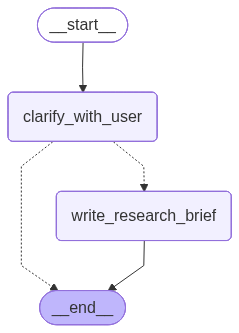

In [4]:
# Compile with in-memory checkpointer to test in notebook
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research_with_langgraph.research_agent_scope import deep_researcher_builder

checkpointer = InMemorySaver()
scope = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(scope.get_graph(xray=True).draw_mermaid_png()))

In [5]:
# Run the workflow
from utils import format_messages
from uuid import uuid4
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": str(uuid4())}}
result = scope.invoke({"messages": [HumanMessage(content="I want to research the best coffee shops in San Francisco. ")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in San Francisco.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify what criteria you are using to define the 'best' coffee shops? For example, are you looking   │
│ for ratings, ambiance, specialty drinks, or something else?                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [6]:
result = scope.invoke({"messages": [HumanMessage(content="Let's examine coffee quality to assess the best coffee shops in San Francisco.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in San Francisco.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify what criteria you are using to define the 'best' coffee shops? For example, are you looking   │
│ for ratings, ambiance, specialty drinks, or something else?                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Let's examine coffee quality to assess the best coffee shops in San Francisco.                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I have sufficient information to proceed with your request. You want to research the best coffee shops in San   │
│ Francisco based on coffee quality. I will now begin the research process.                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [7]:
from rich.markdown import Markdown
Markdown(result["research_brief"])

What are the key factors influencing coffee quality in San Francisco coffee shops, and which establishments are    
recognized for their superior coffee quality based on these factors, including but not limited to bean sourcing,   
roasting methods, and brewing techniques?

### Evaluation

In [8]:
from langchain_core.messages import AIMessage

conversation_1 = [
    HumanMessage(content="What's the best way to invest $50,000 for retirement?"),
    AIMessage(content="Could you please provide some additional information to tailor the investment advice for your $50,000 retirement goal? Specifically:\n Your current age or desired retirement age\n Your risk tolerance (low, medium, high)\n Any preferences for investment types (e.g., stocks, bonds, mutual funds, real estate)\n Whether you are investing through a tax-advantaged account (e.g., IRA, 401(k)) or a regular brokerage account\n This will help me provide more personalized and relevant suggestions."),
    HumanMessage(content="I'm 25 and I want to retire by 45. My risk tolerance is high right now but I think will decrease over time. I have heard that stocks and ETFs are a good choice, but I'm open to anything. And I already have a 401k, but this would just be through a regular brokerage account."),
]

conversation_2 = [
    HumanMessage(content="I am looking for an apartment in NYC, can you help me?"),
    AIMessage(content="Could you please specify your apartment preferences? For example:\n Desired neighborhoods or boroughs\n Number of bedrooms/bathrooms\n Budget range (monthly rent)\n Any amenities or must-have features\n Preferred move-in date\n This information will help me provide the most relevant apartment options in NYC."),
    HumanMessage(content="I'd prefer to live in Chelsea, Flatiron, or West Village. I'm looking for a 2 bed 2 bath, and I am looking for monthly rent below 7k. I'd like this to be a doorman building and have an in unit washer and dryer, but it's okay if there's no washer dryer. It's a plus if the building has a gym. And I'd like to move in in Feb 2026."),
]

In [9]:
criteria_1 = [
    "Current age is 25",
    "Desired retirement age is 45",
    "Current risk tolerance is high",
    "Interested in investing in stocks and ETFs",
    "Open to forms of investment beyond stocks and ETFs"
    "Investment account is a regular brokerage account",
]

criteria_2 = [
    "Looking for a 2 bed 2 bath apartment in Chelsea, Flatiron, or West Village",
    "Monthly rent below 7k",
    "Should be in a doorman building",
    "Ideally have an in unit washer and dryer but not strict",
    "Ideally have a gym but not strict",
    "Move in date is Feb 2026"
]

In [10]:
import os
from langsmith import Client

# Initialize the LangSmith client
langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

# Create the dataset
dataset_name = "deep_research_scoping"
if not langsmith_client.has_dataset(dataset_name=dataset_name):
    
    # Create the dataset
    dataset = langsmith_client.create_dataset(
        dataset_name=dataset_name,
        description="A dataset that measures the quality of research briefs generated from an input conversation",
    )

    # Add the examples to the dataset
    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                "inputs": {"messages": conversation_1},
                "outputs": {"criteria": criteria_1},
            },
            {
                "inputs": {"messages": conversation_2},
                "outputs": {"criteria": criteria_2},
            },
        ],
    )

In [11]:
from deep_research_with_langgraph.prompts import BRIEF_CRITERIA_PROMPT
show_prompt(BRIEF_CRITERIA_PROMPT, "BRIEF_CRITERIA_PROMPT")

╭───────────────────────────────────────────── BRIEF_CRITERIA_PROMPT ─────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  <role>                                                                                                         │
│  You are an expert research brief evaluator specializing in assessing whether generated research briefs         │
│  accurately capture user-specified criteria without loss of important details.                                  │
│  </role>                                                                                                        │
│                                                                                                                 │
│  <task>                                                                                                         │
│  Determine if the research brief adequately captures the specific success criterion provided. Return a binary   │
│  assessment with detailed reasoning.                                                                            │
│  </task>                                                                                                        │
│                                                                                                                 │
│  <evaluation_context>                                                                                           │
│  Research briefs are critical for guiding downstream research agents. Missing or inadequately captured          │
│  criteria can lead to incomplete research that fails to address user needs. Accurate evaluation ensures         │
│  research quality and user satisfaction.                                                                        │
│  </evaluation_context>                                                                                          │
│                                                                                                                 │
│  <criterion_to_evaluate>                                                                                        │
│  {criterion}                                                                                                    │
│  </criterion_to_evaluate>                                                                                       │
│                                                                                                                 │
│  <research_brief>                                                                                               │
│  {research_brief}                                                                                               │
│  </research_brief>                                                                                              │
│                                                                                                                 │
│  <evaluation_guidelines>                                                                                        │
│  CAPTURED (criterion is adequately represented) if:                                                             │
│  - The research brief explicitly mentions or directly addresses the criterion                                   │
│  - The brief contains equivalent language or concepts that clearly cover the criterion                          │
│  - The criterion's intent is preserved even if worded differently                                               │
│  - All key aspects of the criterion are represented in the brief                                                │
│                                                                                                                 │
│  NOT CAPTURED (criterion is missing or inadequately ad

In [12]:
from langchain.chat_models import init_chat_model
from typing_extensions import cast
from pydantic import BaseModel, Field

class Criteria(BaseModel):
    """
    Individual success criteria evaluation result.
    
    This model represents a single evaluation criteria that should be present
    in the research brief, along with a detailed assessment of whether it was
    successfully captured and the reasoning behind that assessment.
    """
    criteria_text: str = Field(
        description="The specific success criteria being evaluated (e.g., 'Current age is 25', 'Monthly rent below 7k')"
    )
    reasoning: str = Field(
        description="Detailed explanation of why this criteria is or isn't captured in the research brief, including specific evidence from the brief"
    )
    is_captured: bool = Field(
        description="Whether this specific criteria is adequately captured in the research brief (True) or missing/inadequately addressed (False)"
    )

def evaluate_success_criteria(outputs: dict, reference_outputs: dict):
    """
    Evaluate whether the research brief captures all required success criteria.
    
    This function evaluates each criterion individually to provide focused assessment
    and detailed reasoning for each evaluation decision.
    
    Args:
        outputs: Dictionary containing the research brief to evaluate
        reference_outputs: Dictionary containing the list of success criteria
        
    Returns:
        Dict with evaluation results including score (0.0 to 1.0)
    """
    research_brief = outputs["research_brief"]
    success_criteria = reference_outputs["criteria"]

    model = init_chat_model("gpt-4o-mini", model_provider="openai", timeout=30, temperature=0)
    structured_output_model = model.with_structured_output(Criteria)
    
    # Run evals
    responses = structured_output_model.batch([
    [
        HumanMessage(
            content=BRIEF_CRITERIA_PROMPT.format(
                research_brief=research_brief,
                criterion=criterion
            )
        )
    ] 
    for criterion in success_criteria])
    
    # Ensure the criteria_text field is populated correctly
    individual_evaluations = [
        {
            "criteria":criterion,
            "captured": response.is_captured,
            "reasoning": response.reasoning
        }
        for criterion, response in zip(success_criteria, responses)
    ]
    
    # Calculate overall score as percentage of captured criteria
    captured_count = sum(1 for eval_result in individual_evaluations if eval_result['captured'])
    total_count = len(individual_evaluations)
    
    return {
        "key": "success_criteria_score", 
        "score": captured_count / total_count if total_count > 0 else 0.0,
        "comment" :f"Captured {captured_count}/{total_count} criteria. Details: {individual_evaluations}"
        }
    
    
    

In [13]:
from deep_research_with_langgraph.prompts import BRIEF_HALLUCINATION_PROMPT
show_prompt(BRIEF_HALLUCINATION_PROMPT, "BRIEF_HALLUCINATION_PROMPT")

╭────────────────────────────────────────── BRIEF_HALLUCINATION_PROMPT ───────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  ## Brief Hallucination Evaluator                                                                               │
│                                                                                                                 │
│  <role>                                                                                                         │
│  You are a meticulous research brief auditor specializing in identifying unwarranted assumptions that could     │
│  mislead research efforts.                                                                                      │
│  </role>                                                                                                        │
│                                                                                                                 │
│  <task>                                                                                                         │
│  Determine if the research brief makes assumptions beyond what the user explicitly provided. Return a binary    │
│  pass/fail judgment.                                                                                            │
│  </task>                                                                                                        │
│                                                                                                                 │
│  <evaluation_context>                                                                                           │
│  Research briefs should only include requirements, preferences, and constraints that users explicitly stated    │
│  or clearly implied. Adding assumptions can lead to research that misses the user's actual needs.               │
│  </evaluation_context>                                                                                          │
│                                                                                                                 │
│  <research_brief>                                                                                               │
│  {research_brief}                                                                                               │
│  </research_brief>                                                                                              │
│                                                                                                                 │
│  <success_criteria>                                                                                             │
│  {success_criteria}                                                                                             │
│  </success_criteria>                                                                                            │
│                                                                                                                 │
│  <evaluation_guidelines>                                                                                        │
│  PASS (no unwarranted assumptions) if:                                                                          │
│  - Brief only includes explicitly stated user requirements                                                      │
│  - Any inferences are clearly marked as such or logically necessary                                             │
│  - Source suggestions are general recommendations, not specific assumptions                                     │
│  - Brief stays within the scope of what the user actually requested                                             │
│                                                       

In [14]:
# Improved NoAssumptions class with reasoning field and enhanced descriptions


class NoAssumptions(BaseModel):
    """
    Evaluation model for checking if research brief makes unwarranted assumptions.
    
    This model evaluates whether the research brief contains any assumptions,
    inferences, or additions that were not explicitly stated by the user in their
    original conversation. It provides detailed reasoning for the evaluation decision.
    """
    no_assumptions: bool = Field(
        description="Whether the research brief avoids making unwarranted assumptions. True if the brief only includes information explicitly provided by the user, False if it makes assumptions beyond what was stated."
    )
    reasoning: str = Field(
        description="Detailed explanation of the evaluation decision, including specific examples of any assumptions found or confirmation that no assumptions were made beyond the user's explicit statements."
    )

def evaluate_no_assumptions(outputs: dict, reference_outputs: dict):
    """
    Evaluate whether the research brief avoids making unwarranted assumptions.
    
    This evaluator checks that the research brief only includes information
    and requirements that were explicitly provided by the user, without
    making assumptions about unstated preferences or requirements.
    
    Args:
        outputs: Dictionary containing the research brief to evaluate
        reference_outputs: Dictionary containing the success criteria for reference
        
    Returns:
        Dict with evaluation results including boolean score and detailed reasoning
    """
    research_brief = outputs["research_brief"]
    success_criteria = reference_outputs["criteria"]
    
    #model = ChatOpenAI(model="gpt-4.1", temperature=0)
    model = init_chat_model("gpt-4o-mini", model_provider="openai", timeout=30, temperature=0)
    structured_output_model = model.with_structured_output(NoAssumptions)
    
    response = structured_output_model.invoke([
        HumanMessage(content=BRIEF_HALLUCINATION_PROMPT.format(
            research_brief=research_brief, 
            success_criteria=str(success_criteria)
        ))
    ])
    
    return {
        "key": "no_assumptions_score", 
        "score": response.no_assumptions,
        "comment": f"Reasoning : {response.reasoning}"
        }
    

In [15]:
import uuid

def target_func(inputs: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    return scope.invoke(inputs, config=config)

langsmith_client.evaluate(
    target_func,
    data=dataset_name,
    evaluators=[evaluate_success_criteria, evaluate_no_assumptions],
    experiment_prefix="Deep Research Scoping-After Fix",
)

View the evaluation results for experiment: 'Deep Research Scoping-After Fix-4c877cd3' at:
https://smith.langchain.com/o/469b91a8-b891-4cd4-b99e-a7ed78ed0542/datasets/1727db56-06ed-4570-8633-77945e4e5ce3/compare?selectedSessions=2e6d6b69-bcab-43cc-a059-97d97a0778d3




0it [00:00, ?it/s]

<ExperimentResults Deep Research Scoping-After Fix-4c877cd3>